In [40]:
### Importing Required Libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from numpy import array, asarray, zeros
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Flatten, GlobalMaxPooling1D, Conv1D, SpatialDropout1D, Input
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#load the dataset

df=pd.read_csv(r'C:\Users\sunan\Desktop\Projects\Fake or Real\train.csv')
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [3]:
df = df.drop(['id', 'author', 'text'], axis=1)
df

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1
...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",0
20797,Macy’s Is Said to Receive Takeover Approach by...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [4]:
df.columns.isna().sum()

0

In [5]:
df.shape

(20800, 2)

<AxesSubplot:xlabel='label', ylabel='count'>

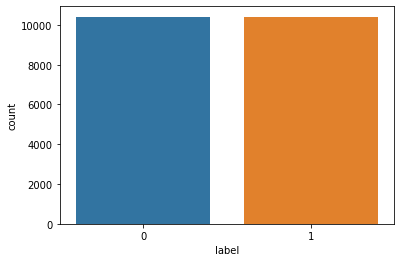

In [7]:
sns.countplot(x = 'label', data =df)

In [10]:
import random
randomlist = [random.randint(1,len(df.title)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[randomlist,:].head(10) # Returns the rows with the index and display it

,title,label
19052,Matthews Thinks Trump Will Probably Face a Pri...,0
10190,OFF TOPIC: Unlike Muslims…horses actually do h...,1
12583,"Interview: Sarah Anastasia, Muslim Makeup Arti...",1
18762,Скандал вокруг Пак Кын Хе – специальный прокур...,1
4237,China’s Growing Amphibious Capabilities (two-p...,1
3957,NYT: Whites Must Know Their Place,1
9101,Border Patrol Agents Arrest Previously Deporte...,0
16424,"Donald Trump, Samsung, Yemen: Your Monday Even...",0
17412,I’ve just been threatened by my foreign owned-...,1
13564,Istanbul Airport Attack Leaves at Least 41 Dea...,0


In [13]:
#News title labels

news = {0:"REAL", 1:"FAKE"}
def label_decoder(label):
    return news[label]
df.label = df.label.apply(lambda x: label_decoder(x))
df.head()

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,FAKE
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",REAL
2,Why the Truth Might Get You Fired,FAKE
3,15 Civilians Killed In Single US Airstrike Hav...,FAKE
4,Iranian woman jailed for fictional unpublished...,FAKE


In [14]:
#preprocessing the data


def data_cleaning(text):
    text = str(text).lower()  # convert to lowercase
    text = re.sub(pattern=r'\s+[a-zA-Z]\s+',repl='',string = text)   # remove single characters
    text = re.sub(r'https?://\S+|www\.\S+',repl='',string = text)   # Remove URls, whitespace characters 
    text = re.sub(r'[^a-z\s]',' ',string = text)# Removes all the special characters, digits from 0-9 and Capital Letters
    text = re.sub(r'\s+', ' ', string = text)  # Substituting multiple spaces with single space
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text.split() if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [15]:
df.title = df.title.apply(lambda x: data_cleaning(x))

In [16]:
df

,title,label
0,hous dem aid even see comey letter jason chaff...,FAKE
1,flynn hillari clinton big woman campu breitbart,REAL
2,truth might get fire,FAKE
3,civilian kill singl us airstrik identifi,FAKE
4,iranian woman jail fiction unpublish stori wom...,FAKE
...,...,...
20795,rapper trump poster child white supremaci,REAL
20796,n f l playoff schedul matchup odd new york time,REAL
20797,maci said receiv takeov approach hudson bay ne...,REAL
20798,nato russia hold parallel exercis balkan,FAKE


In [17]:
max_no_words = 5000
max_sequence_length = 30

In [18]:
#data Splitting: train, test

train_data, test_data = train_test_split(df, test_size=0.20,random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16640
Test Data size 4160


In [19]:
train_data.head(10)

,title,label
18751,krauthamm question obama left behind landmin t...,REAL
13847,employe sue four univers retir plan fee new yo...,REAL
20028,white hous petit remov soro own vote machin hi...,FAKE
9874,unit state critic israel west bank settlement ...,REAL
609,chao terror tie make venezuela direct threat u...,REAL
6185,emerg evacu order orovil dam spillway near failur,REAL
1190,u strike syria bring fleet hope caught brutal ...,REAL
13608,elizabeth warren fail disclos million line cre...,REAL
12688,trump foundat may use money benefit one new yo...,REAL
15304,fewer tomato ketchup east european pursu parit...,REAL


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.title)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 14909


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.title),
                        maxlen = max_sequence_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.title),
                       maxlen = max_sequence_length)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (16640, 30)
Testing X Shape: (4160, 30)


In [24]:
train_data.label.unique().tolist()

['REAL', 'FAKE']

In [26]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

LabelEncoder()

In [28]:
y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16640, 1)
y_test shape: (4160, 1)


In [29]:
## Embedding Layer

In [30]:
glv_emb = open(r'C:\Users\sunan\Desktop\Projects\Sentiment analysis(chunks)\Amazon Food Review Analysis\Glove Embedding\glove.6B.100d.txt', encoding='utf8')

In [31]:
LR = 1e-3
EMBEDDING_DIM = 100
BATCH_SIZE = 1024
EPOCHS = 10

In [32]:
embeddings_index = {}

for line in glv_emb:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
        
glv_emb.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [33]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
import tensorflow as tf
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

In [42]:
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())


In [43]:
model.add(Dense(1, activation = 'sigmoid'))

In [44]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1490900   
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 1)                 3001      
                                                                 
Total params: 1,493,901
Trainable params: 3,001
Non-trainable params: 1,490,900
_________________________________________________________________


In [46]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
17/17 [==============================] - 1s 24ms/step - loss: 0.6305 - acc: 0.5588 - val_loss: 0.5547 - val_acc: 0.6389
Epoch 2/10
17/17 [==============================] - 0s 14ms/step - loss: 0.5080 - acc: 0.7514 - val_loss: 0.4653 - val_acc: 0.8137
Epoch 3/10
17/17 [==============================] - 0s 14ms/step - loss: 0.4362 - acc: 0.8397 - val_loss: 0.4109 - val_acc: 0.8526
Epoch 4/10
17/17 [==============================] - 0s 14ms/step - loss: 0.3898 - acc: 0.8660 - val_loss: 0.3746 - val_acc: 0.8805
Epoch 5/10
17/17 [==============================] - 0s 14ms/step - loss: 0.3584 - acc: 0.8802 - val_loss: 0.3499 - val_acc: 0.8851
Epoch 6/10
17/17 [==============================] - 0s 14ms/step - loss: 0.3360 - acc: 0.8861 - val_loss: 0.3319 - val_acc: 0.8913
Epoch 7/10
17/17 [==============================] - 0s 13ms/step - loss: 0.3194 - acc: 0.8894 - val_loss: 0.3186 - val_acc: 0.8938
Epoch 8/10
17/17 [==============================] - 0s 14ms/step - loss: 0.3066 - a

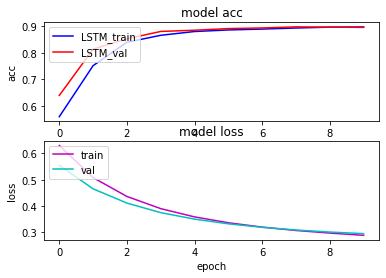

In [49]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model acc')
at.set_ylabel('acc')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [52]:
def predictions(text):
    text1 = tokenizer.texts_to_sequences(text)
    text_padded = pad_sequences(
        text1,
        padding = 'post',
        maxlen = max_sequence_length
    )
    pred = model.predict(text_padded)
    return 'Fake' if pred[0] >= 0.5 else 'Real'

In [51]:
####### Predict 

In [60]:
#load the dataset

test_df=pd.read_csv(r'C:\Users\sunan\Desktop\Projects\Fake or Real\test.csv')
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [57]:
predictions([test_df.iloc[100].title])

'Real'

In [58]:
print([test_df.iloc[100].title])

['Reuters: Vice Admiral Harward Trump Pick for National Security Adviser - Breitbart']
